# SOAI Lab: Smart Home Energy Consumption Prediction


## Part 0 : Import used libraries

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Part 1 : Understand the data and Exploring it

### 1.1. Load the Training Data :
- The first step is to load the training data into the system. This is typically done using a data

In [75]:
# Load the training data
train_data = pd.read_csv('data/train_energy.csv')

### 1.2. Inspect the Training Data
- Inspect the training data to understand the distribution of the target variable and the features. This step is crucial

In [76]:
# Display the first few rows of the training data
print(train_data)

# Display information about the training data
print(train_data.info())

# Display summary statistics of the training data
print(train_data.describe())

# Check for missing values in the training data
print(train_data.isnull().sum())

                  DateTime  EnergyConsumption(kWh)
0      2015-11-01 00:00:00                      15
1      2015-11-01 01:00:00                      13
2      2015-11-01 02:00:00                      10
3      2015-11-01 03:00:00                       7
4      2015-11-01 04:00:00                       9
...                    ...                     ...
10244  2016-12-31 20:00:00                      37
10245  2016-12-31 21:00:00                      32
10246  2016-12-31 22:00:00                      33
10247  2016-12-31 23:00:00                      32
10248  2017-01-01 00:00:00                      27

[10249 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10249 entries, 0 to 10248
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   DateTime                10249 non-null  object
 1   EnergyConsumption(kWh)  10249 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 160.

### 1.3. Extracting Meaningful Informations
- Extracting temporal features form Datetime

In [77]:
# Convert DateTime to pandas datetime object
train_data['DateTime'] = pd.to_datetime(train_data['DateTime'])

# Extract features
train_data['hour'] = train_data['DateTime'].dt.hour
train_data['day_of_week'] = train_data['DateTime'].dt.dayofweek  # Monday=0, Sunday=6
train_data['is_weekend'] = train_data['day_of_week'] >= 5
train_data['month'] = train_data['DateTime'].dt.month
train_data['day_of_year'] = train_data['DateTime'].dt.dayofyear
train_data['week_of_year'] = train_data['DateTime'].dt.isocalendar().week

### 1.4. Visualising Trends
- Visualising trends is an important aspect of data analysis. It helps to identify patterns, relationships
and anomalies in the data. There are several types of visualisations that can be used to
visualise trends

#### 1.4.1. Hourly Trends

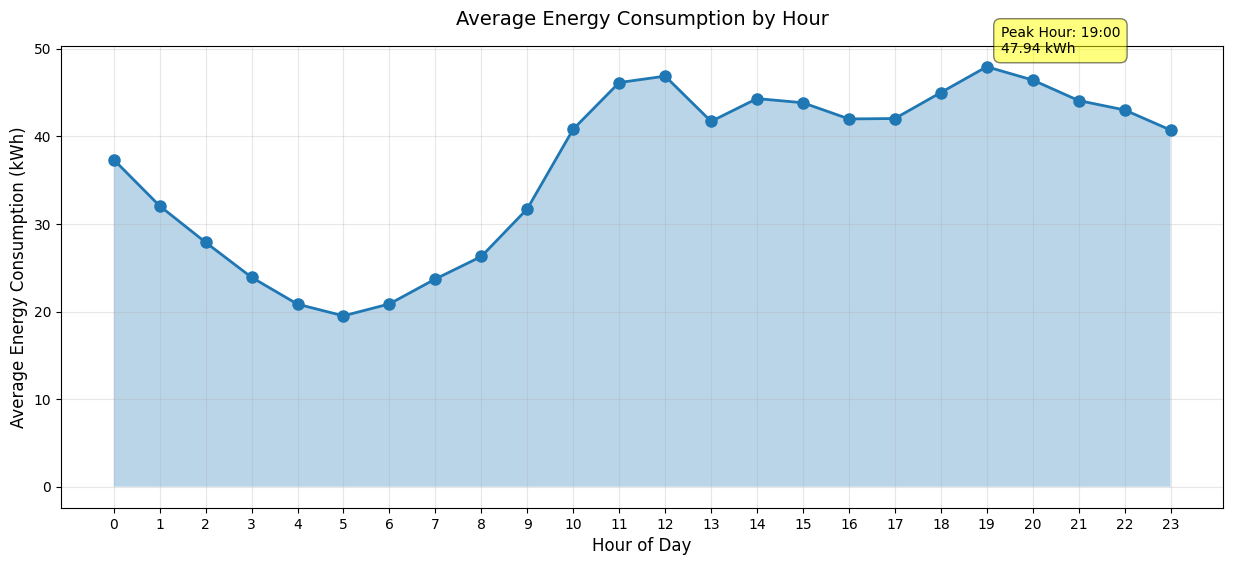

In [78]:
plt.figure(figsize=(15, 6))
hourly_avg = train_data.groupby('hour')['EnergyConsumption(kWh)'].mean()

plt.plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2, markersize=8)
plt.fill_between(hourly_avg.index, hourly_avg.values, alpha=0.3)
plt.title('Average Energy Consumption by Hour', fontsize=14, pad=15)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Average Energy Consumption (kWh)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24))

# Add peak hours annotation
peak_hour = hourly_avg.idxmax()
plt.annotate(f'Peak Hour: {peak_hour}:00\n{hourly_avg[peak_hour]:.2f} kWh', 
            xy=(peak_hour, hourly_avg[peak_hour]),
            xytext=(10, 10), textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))
plt.show()

#### 1.4.2. Daily Trends

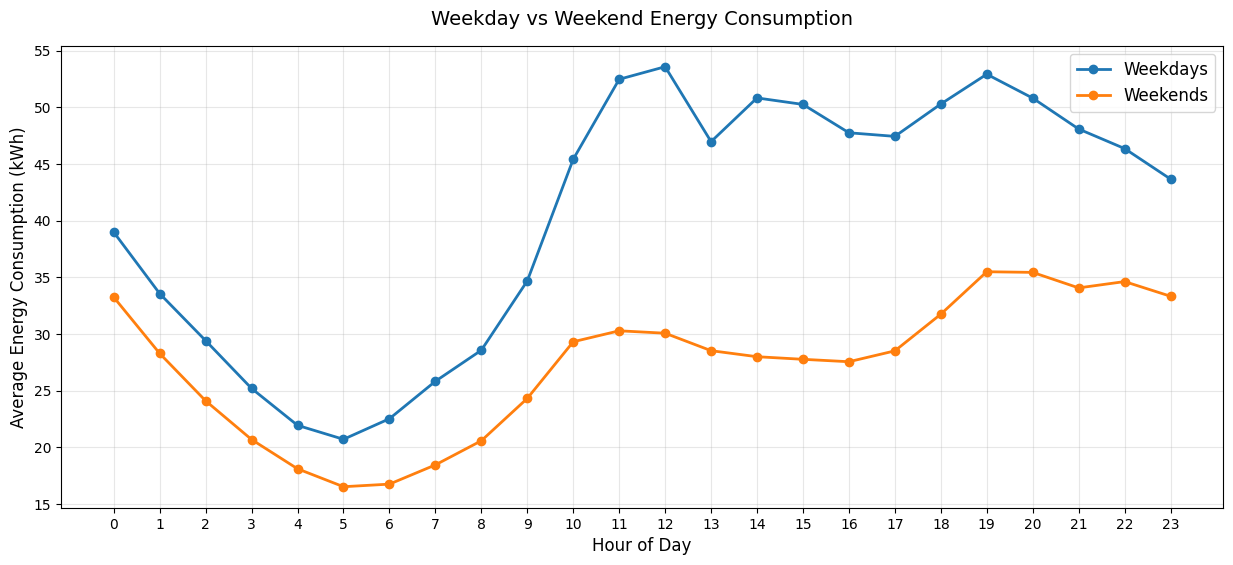

In [79]:
plt.figure(figsize=(15, 6))

# Calculate averages
weekday_hourly = train_data[~train_data['is_weekend']].groupby('hour')['EnergyConsumption(kWh)'].mean()
weekend_hourly = train_data[train_data['is_weekend']].groupby('hour')['EnergyConsumption(kWh)'].mean()

# Plot both lines
plt.plot(weekday_hourly.index, weekday_hourly.values, label='Weekdays', marker='o', linewidth=2)
plt.plot(weekend_hourly.index, weekend_hourly.values, label='Weekends', marker='o', linewidth=2)
plt.title('Weekday vs Weekend Energy Consumption', fontsize=14, pad=15)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Average Energy Consumption (kWh)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.xticks(range(0, 24))
plt.show()

#### 1.4.3. Weekly Trends

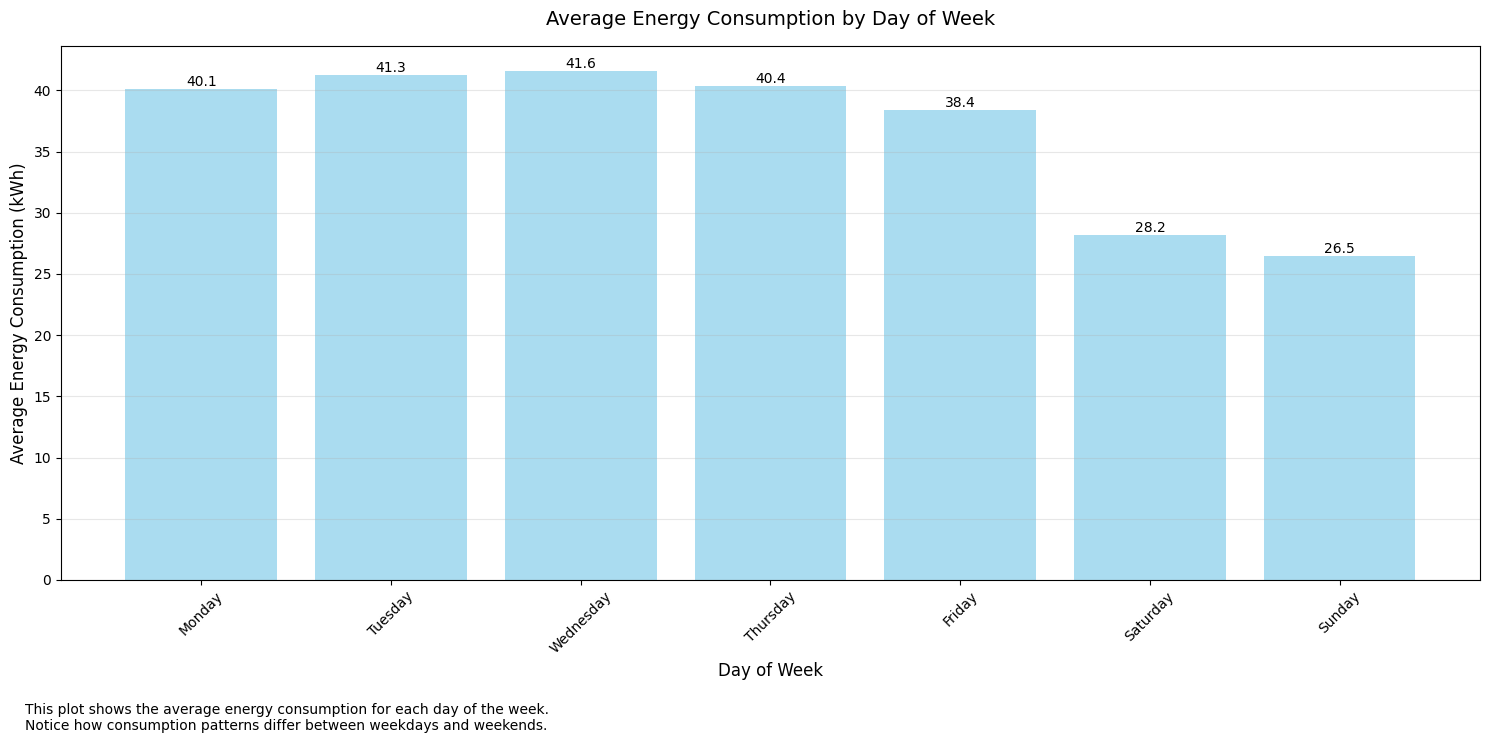

In [80]:
plt.figure(figsize=(15, 7))

daily_consumption = train_data.groupby('day_of_week')['EnergyConsumption(kWh)'].mean()

# Create bar plot
bars = plt.bar(daily_consumption.index, daily_consumption.values, 
               color='skyblue', alpha=0.7)

# Customize the plot
plt.title('Average Energy Consumption by Day of Week', fontsize=14, pad=15)
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Average Energy Consumption (kWh)', fontsize=12)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}',
             ha='center', va='bottom')

# Customize x-axis labels
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.xticks(range(7), days, rotation=45)

# Add grid for better readability
plt.grid(True, axis='y', alpha=0.3)

# Add a brief explanation
plt.figtext(0.02, -0.05, 
            'This plot shows the average energy consumption for each day of the week.\nNotice how consumption patterns differ between weekdays and weekends.',
            fontsize=10, ha='left')

plt.tight_layout()
plt.show()

#### 1.4.4. Mounthly Trends

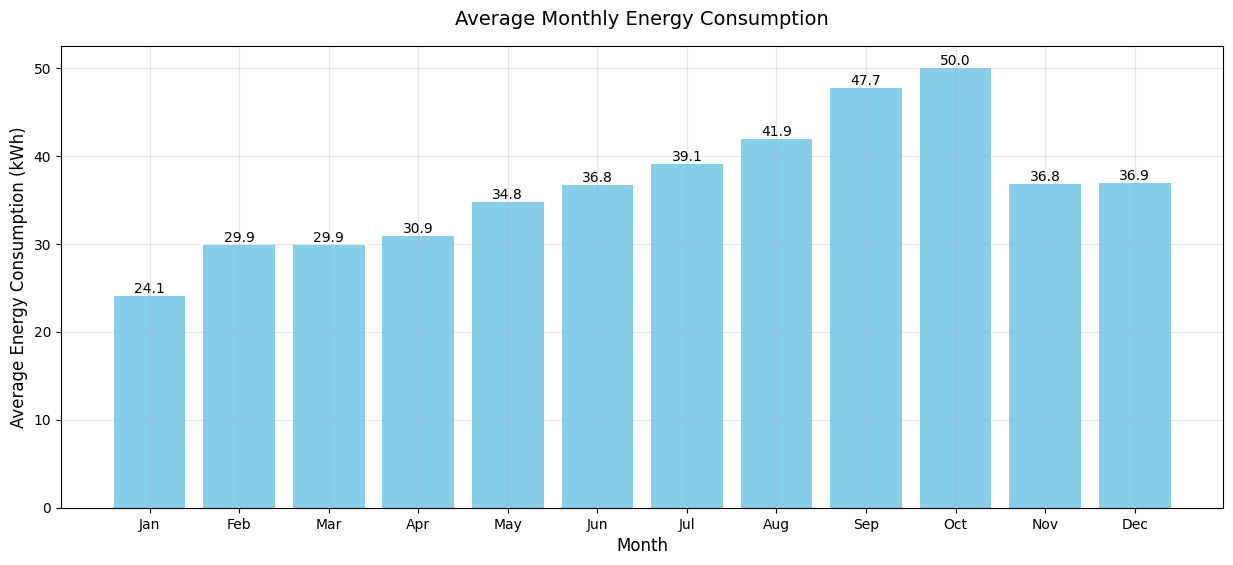

In [81]:
plt.figure(figsize=(15, 6))

# Calculate monthly averages
monthly_avg = train_data.groupby('month')['EnergyConsumption(kWh)'].mean()

# Create seasonal plot
bars = plt.bar(monthly_avg.index, monthly_avg.values, color='skyblue')
plt.title('Average Monthly Energy Consumption', fontsize=14, pad=15)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Energy Consumption (kWh)', fontsize=12)
plt.grid(True, alpha=0.3)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}',
             ha='center', va='bottom')

plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

#### 1.4.5. Time Series Plot

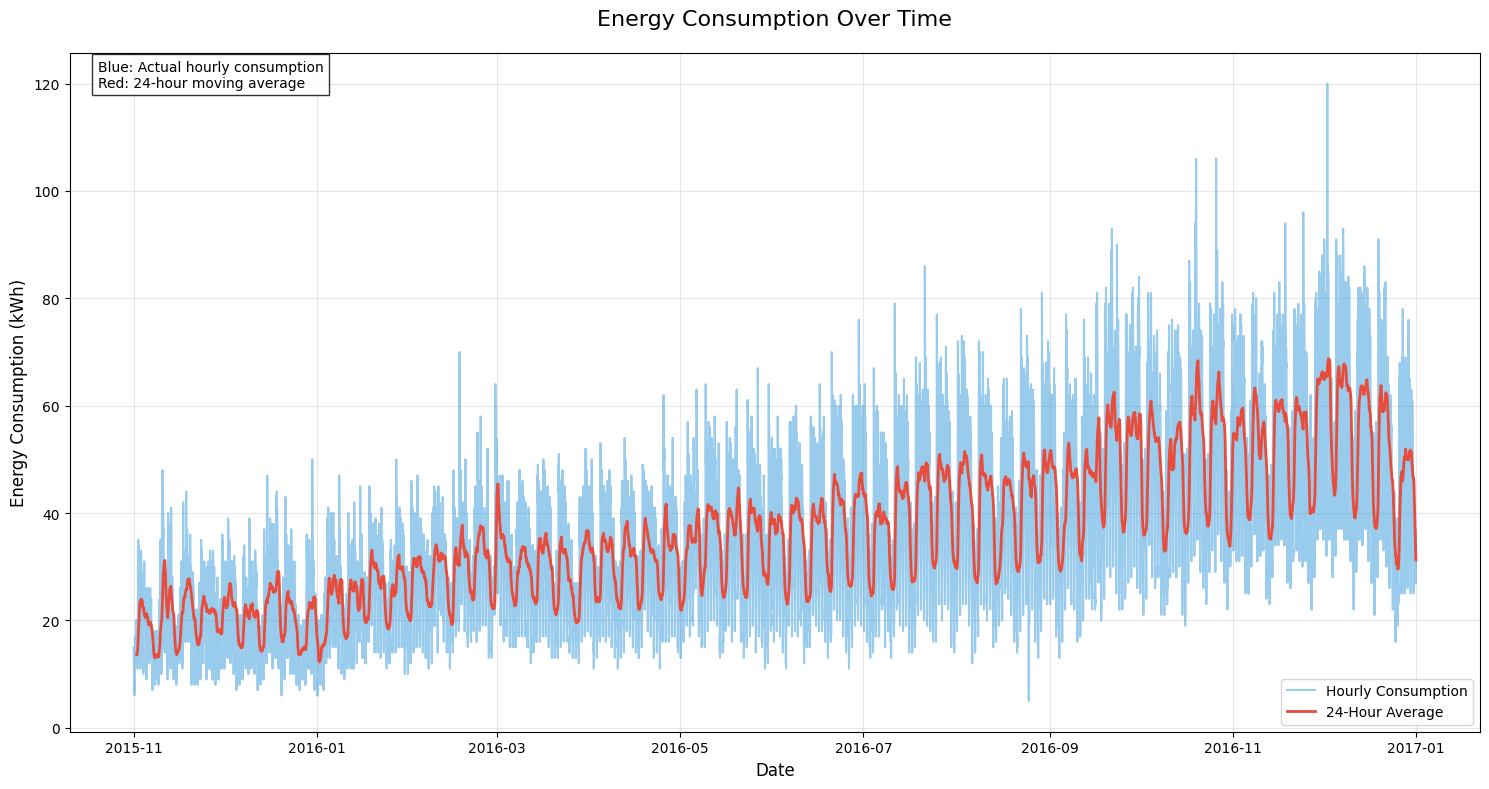

In [82]:
plt.figure(figsize=(15, 8))

plt.plot(train_data['DateTime'], train_data['EnergyConsumption(kWh)'],
         color='#3498db', alpha=0.5, label='Hourly Consumption')

# Add rolling average
window_size = 24  # 24 hours
rolling_avg = train_data['EnergyConsumption(kWh)'].rolling(window=window_size).mean()
plt.plot(train_data['DateTime'], rolling_avg,
         color='#e74c3c', linewidth=2, label='24-Hour Average')

# Customize plot
plt.title('Energy Consumption Over Time', fontsize=16, pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Energy Consumption (kWh)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)

# Add annotations
plt.annotate('Blue: Actual hourly consumption\nRed: 24-hour moving average',
            xy=(0.02, 0.95), xycoords='axes fraction',
            bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

### 1.5. Correlation with Target Variable
The correlation between the target variable and the feature variables is an essential aspect of feature selection.
- **Positive Correlation**: If the correlation between the target variable and a feature variable is positive,
- **Negative Correlation**: If the correlation between the target variable and a feature variable is negative,
- **No Correlation**: If the correlation between the target variable and a feature variable is zero.

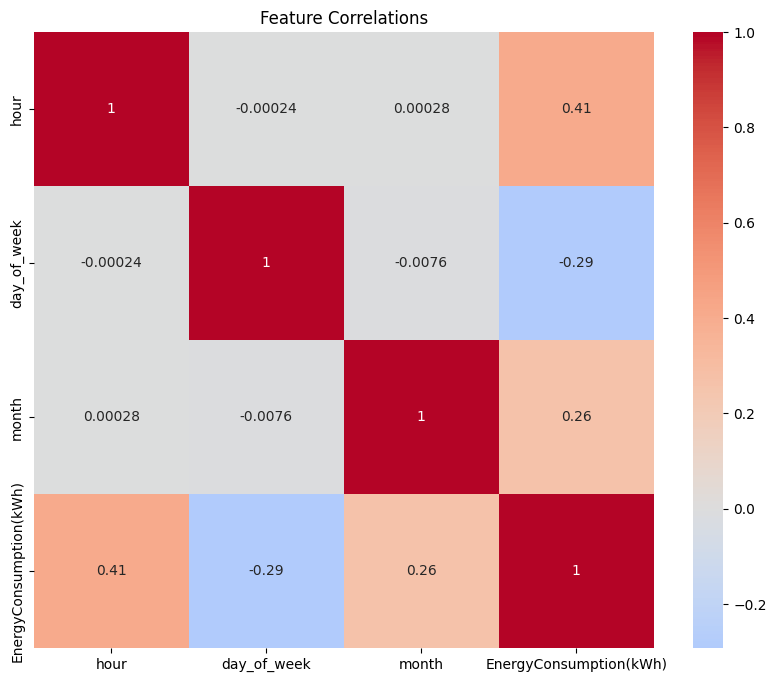

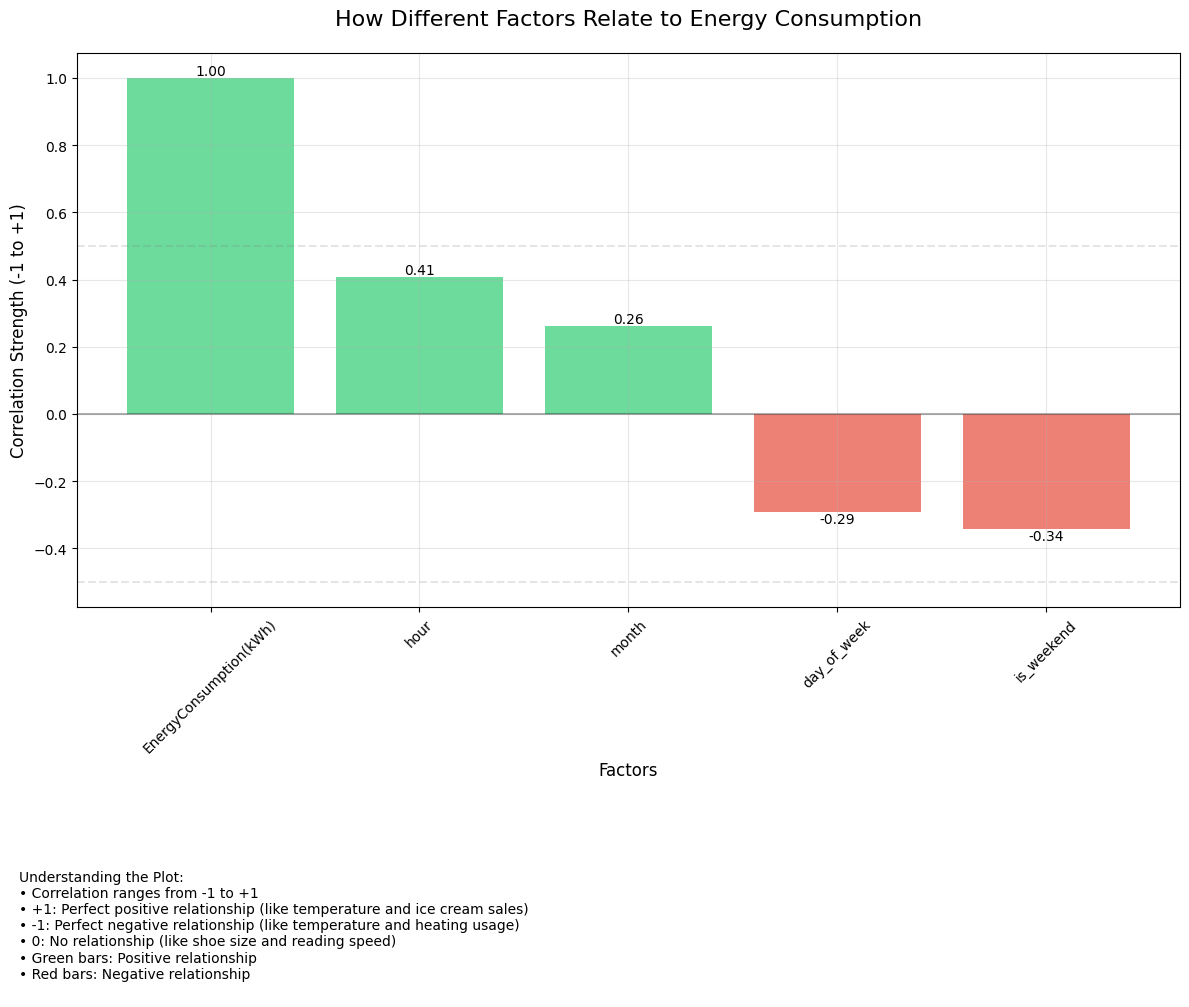


Relationship Strength Summary:
• When EnergyConsumption(kWh) goes up, energy consumption tends to increases (strong relationship: 1.00)
• When hour goes up, energy consumption tends to increases (moderate relationship: 0.41)
• When month goes up, energy consumption tends to increases (weak relationship: 0.26)
• When day_of_week goes up, energy consumption tends to decreases (weak relationship: -0.29)
• When is_weekend goes up, energy consumption tends to decreases (moderate relationship: -0.34)


In [83]:
# Cell 10: Correlation Analysis
# Calculate correlations
correlation_matrix = train_data[['hour', 'day_of_week', 'month', 'EnergyConsumption(kWh)']].corr()

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlations')
plt.show()

# Create figure
plt.figure(figsize=(12, 8))

# Calculate correlations with target
features = ['hour', 'day_of_week', 'month', 'is_weekend', 'EnergyConsumption(kWh)']
correlation_matrix = train_data[features].corr()['EnergyConsumption(kWh)'].sort_values(ascending=False)

# Create bar plot
colors = ['#2ecc71' if x >= 0 else '#e74c3c' for x in correlation_matrix]
bars = plt.bar(range(len(correlation_matrix)), 
               correlation_matrix,
               color=colors,
               alpha=0.7)

# Customize appearance
plt.title('How Different Factors Relate to Energy Consumption', fontsize=16, pad=20)
plt.xlabel('Factors', fontsize=12)
plt.ylabel('Correlation Strength (-1 to +1)', fontsize=12)

# Add feature labels
plt.xticks(range(len(correlation_matrix)), 
           correlation_matrix.index,
           rotation=45)

# Add correlation values on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., 
             height,
             f'{height:.2f}',
             ha='center', 
             va='bottom' if height >= 0 else 'top')

# Add reference lines
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.2)
plt.axhline(y=-0.5, color='gray', linestyle='--', alpha=0.2)

# Add explanation box
explanation_text = '''
Understanding the Plot:
• Correlation ranges from -1 to +1
• +1: Perfect positive relationship (like temperature and ice cream sales)
• -1: Perfect negative relationship (like temperature and heating usage)
• 0: No relationship (like shoe size and reading speed)
• Green bars: Positive relationship
• Red bars: Negative relationship
'''

plt.figtext(0.02, -0.25, explanation_text, fontsize=10, ha='left')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print numerical interpretation
print("\nRelationship Strength Summary:")
for feature, corr in correlation_matrix.items():
    strength = "strong" if abs(corr) > 0.5 else "moderate" if abs(corr) > 0.3 else "weak"
    direction = "increases" if corr > 0 else "decreases"
    print(f"• When {feature} goes up, energy consumption tends to {direction} ({strength} relationship: {corr:.2f})")

### 1.6. Time Series Decomposition
- Time series decomposition is a technique used to break down a time series into its underlying components. This can
include trend, seasonality, and residuals. The goal of decomposition is to identify the underlying patterns and
trends in the data, which can be useful for forecasting and other applications.

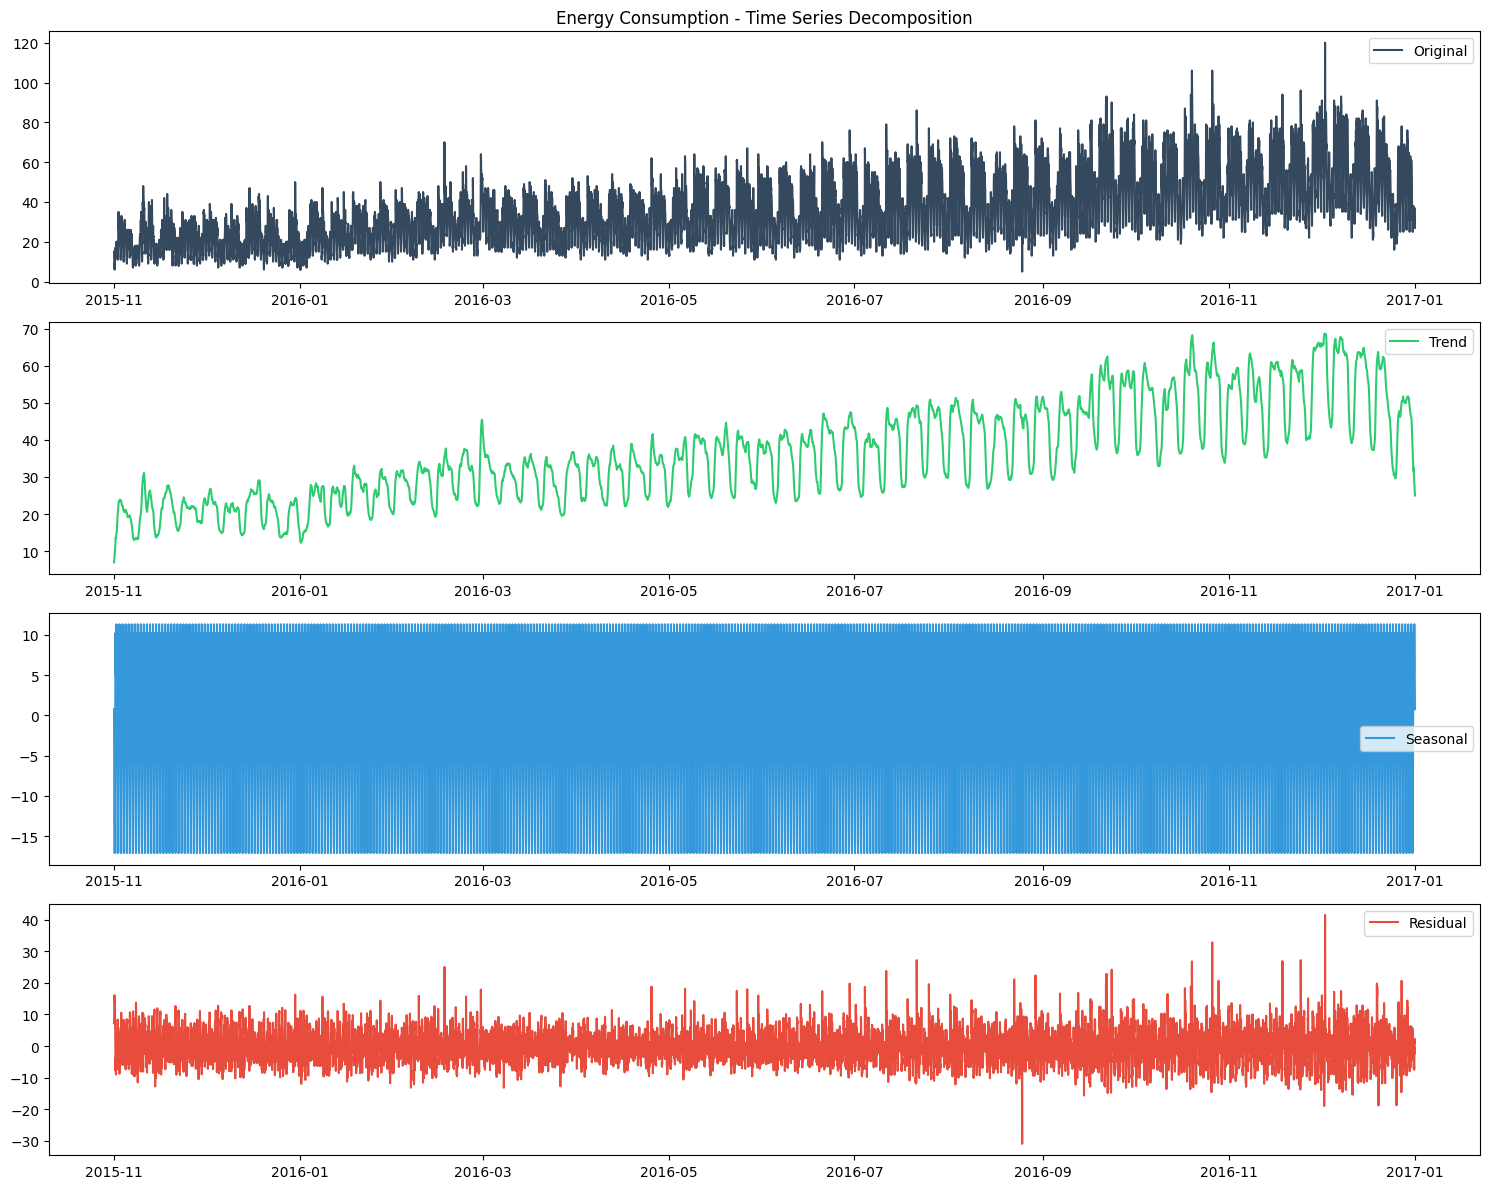

In [84]:
# Prepare time series data
ts_data = train_data.set_index('DateTime')['EnergyConsumption(kWh)']

# Decompose series
decomposition = seasonal_decompose(ts_data, 
                                 period=24,  # Daily seasonality
                                 extrapolate_trend='freq')

# Visualize components
plt.figure(figsize=(15, 12))

# Plot components
components = ['Original', 'Trend', 'Seasonal', 'Residual']
data = [ts_data, decomposition.trend, 
        decomposition.seasonal, decomposition.resid]
colors = ['#34495e', '#2ecc71', '#3498db', '#e74c3c']

for idx, (title, data, color) in enumerate(zip(components, data, colors), 1):
    plt.subplot(4, 1, idx)
    plt.plot(data, color=color, label=title)
    plt.legend()
    if idx == 1:
        plt.title('Energy Consumption - Time Series Decomposition')

plt.tight_layout()
plt.show()

## Step 2 : Data Splitting

### 2.1. Sort and Split into train and validation

In [85]:
# Sort by DateTime
train_data = train_data.sort_values(by='DateTime')

# Define split index
split_index = int(0.8 * len(train_data))

# Split into train and validation
train_df = train_data[:split_index]
val_df = train_data[split_index:]

### 2.2. Visualize Split data

/home/adel_hb/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


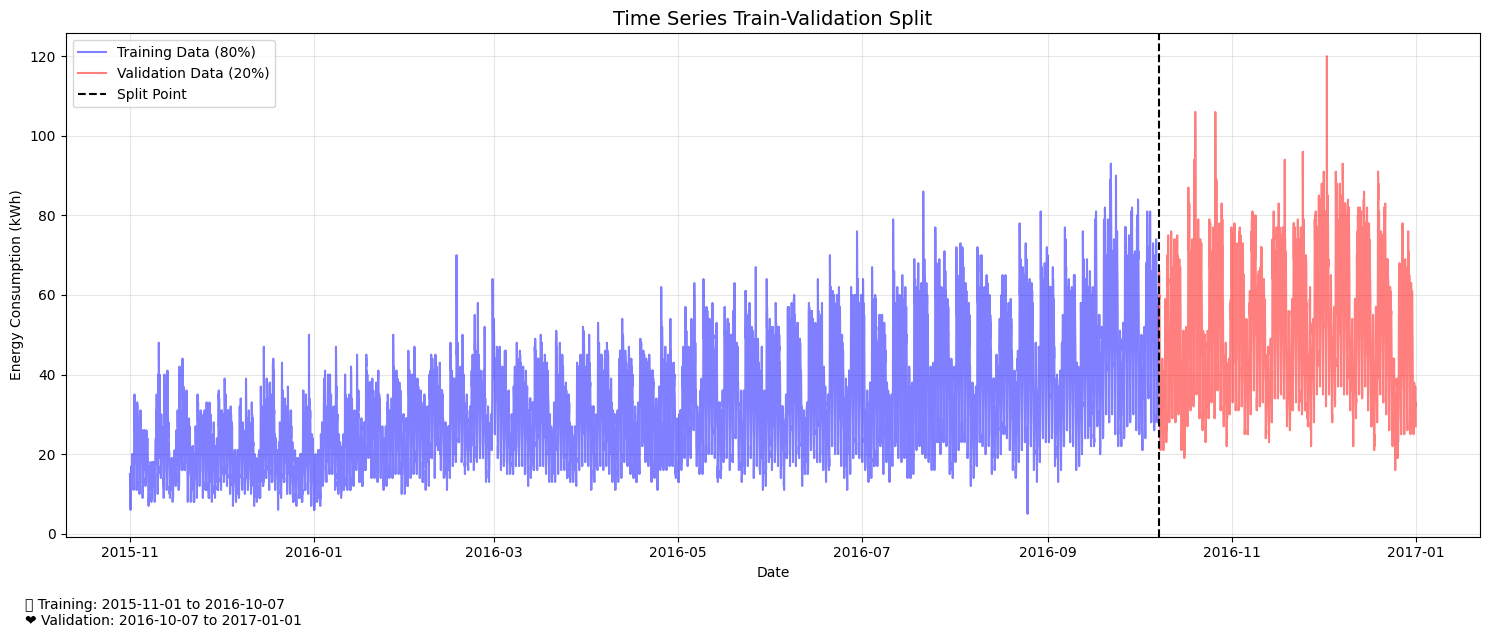

In [86]:
# Cell 2: Visualize Split
plt.figure(figsize=(15, 6))

# Plot training data
plt.plot(train_df['DateTime'], train_df['EnergyConsumption(kWh)'],
         color='blue', alpha=0.5, label='Training Data (80%)')

# Plot validation data
plt.plot(val_df['DateTime'], val_df['EnergyConsumption(kWh)'],
         color='red', alpha=0.5, label='Validation Data (20%)')

# Add split line
split_date = train_df['DateTime'].max()
plt.axvline(x=split_date, color='black', linestyle='--', label='Split Point')

# Customize plot
plt.title('Time Series Train-Validation Split', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Energy Consumption (kWh)')
plt.legend()
plt.grid(True, alpha=0.3)

# Add explanation
plt.figtext(0.02, -0.05, 
            f'🟢 Training: {train_df["DateTime"].min().date()} to {train_df["DateTime"].max().date()}\n' +
            f'❤️ Validation: {val_df["DateTime"].min().date()} to {val_df["DateTime"].max().date()}',
            fontsize=10, ha='left')

plt.tight_layout()
plt.show()

### 2.3. Print Split Informations

In [87]:

# Cell 3: Print Split Information
print("\nTime Series Split Summary:")
print(f"Total samples: {len(train_data)}")
print(f"Training samples: {len(train_df)} ({len(train_df)/len(train_data)*100:.1f}%)")
print(f"Validation samples: {len(val_df)} ({len(val_df)/len(train_data)*100:.1f}%)")
print(f"\nTraining period: {train_df['DateTime'].min()} to {train_df['DateTime'].max()}")
print(f"Validation period: {val_df['DateTime'].min()} to {val_df['DateTime'].max()}")



Time Series Split Summary:
Total samples: 10249
Training samples: 8199 (80.0%)
Validation samples: 2050 (20.0%)

Training period: 2015-11-01 00:00:00 to 2016-10-07 14:00:00
Validation period: 2016-10-07 15:00:00 to 2017-01-01 00:00:00


### 2.4. Save data to pickle

In [88]:
splits = {
    'train': train_df,
    'validation': val_df
}

# Save to pickle
import pickle
with open('timeseries_splits.pkl', 'wb') as f:
    pickle.dump(splits, f)

print("\nSplit data saved successfully!")


Split data saved successfully!


## Step 3 : Feature Engineering

In [89]:
# Load the split data
with open('timeseries_splits.pkl', 'rb') as f:
    splits = pickle.load(f)

train_df = splits['train']
val_df = splits['validation']


In [90]:

# Cell 2: Add External Contextual Data
def add_holiday_feature(df):
    df = df.copy()  # Ensure we are working with a copy
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start=df['DateTime'].min(), end=df['DateTime'].max())
    df['is_holiday'] = df['DateTime'].isin(holidays).astype(int)
    return df

train_df = add_holiday_feature(train_df)
val_df = add_holiday_feature(val_df)

print("Added holiday feature:")
print(train_df.head())

# Cell: Filter and Display Rows with is_holiday = 1
holiday_rows = train_df[train_df['is_holiday'] == 1]
print(holiday_rows.head())

Added holiday feature:
             DateTime  EnergyConsumption(kWh)  hour  day_of_week  is_weekend  \
0 2015-11-01 00:00:00                      15     0            6        True   
1 2015-11-01 01:00:00                      13     1            6        True   
2 2015-11-01 02:00:00                      10     2            6        True   
3 2015-11-01 03:00:00                       7     3            6        True   
4 2015-11-01 04:00:00                       9     4            6        True   

   month  day_of_year  week_of_year  is_holiday  
0     11          305            44           0  
1     11          305            44           0  
2     11          305            44           0  
3     11          305            44           0  
4     11          305            44           0  
       DateTime  EnergyConsumption(kWh)  hour  day_of_week  is_weekend  month  \
240  2015-11-11                      28     0            2       False     11   
600  2015-11-26                   

## Step 4 : Model Selection and Training

### 4.1. Set Up ARIMA Model

#### Learn about ARIMA components (AR, I, MA)
- ARIMA stands for AutoRegressive Integrated Moving Average. It is a popular statistical method for time series forecasting.
- Let's break down the components of ARIMA:
- AR (AutoRegressive): This component uses the dependency between an observation and a number of lagged observations (i.e., previous time steps).
- I (Integrated): This component uses differencing of observations (subtracting an observation from an observation at the previous time step) to make the time series stationary (i.e., to remove trends and seasonality).
- MA (Moving Average): This component uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.


ADF Statistic: -6.850248409481416
p-value: 1.701521303747482e-09
Critical Values:
   1%, -3.431151440553312
Critical Values:
   5%, -2.861894180267881
Critical Values:
   10%, -2.566958525380525


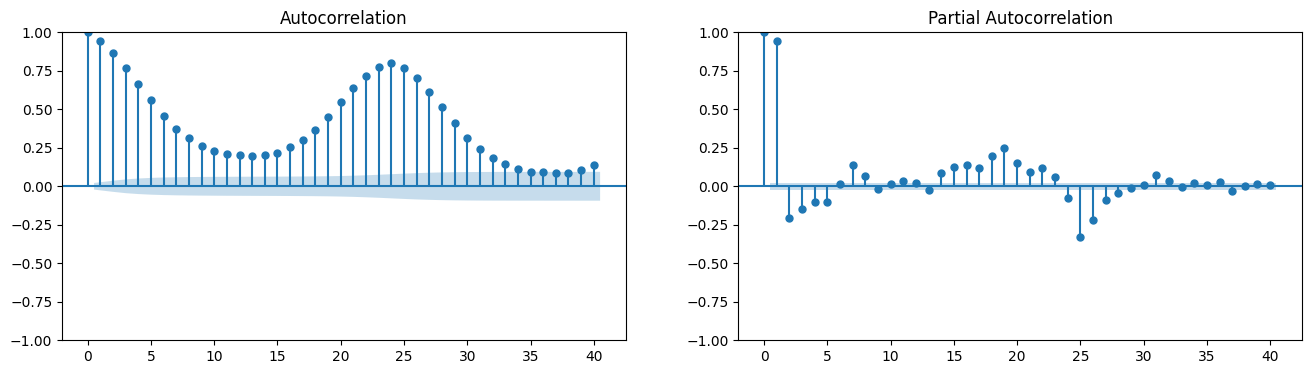

ADF Statistic: -17.40326249658865
p-value: 4.933144361612186e-30
Critical Values:
   1%, -3.431151440553312
Critical Values:
   5%, -2.861894180267881
Critical Values:
   10%, -2.566958525380525


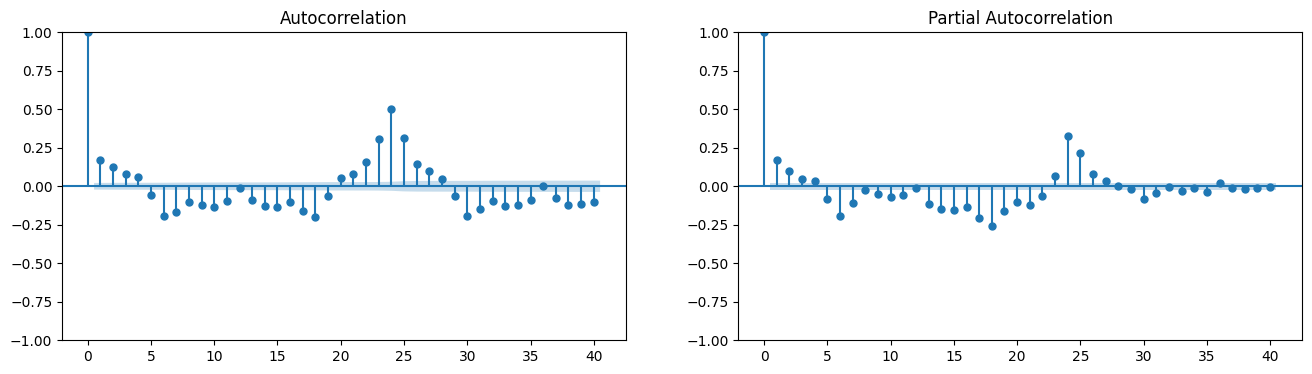

In [91]:

# Check for stationarity using Augmented Dickey-Fuller test
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print('Critical Values:')
        print(f'   {key}, {value}')

# Plot ACF and PACF to determine AR and MA components
def plot_acf_pacf(timeseries, lags=40):
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))
    plot_acf(timeseries, lags=lags, ax=axes[0])
    plot_pacf(timeseries, lags=lags, ax=axes[1])
    plt.show()

# Check stationarity of the time series
check_stationarity(train_df['EnergyConsumption(kWh)'])

# Plot ACF and PACF
plot_acf_pacf(train_df['EnergyConsumption(kWh)'])

# Differencing to make the time series stationary
train_df['EnergyConsumption_diff'] = train_df['EnergyConsumption(kWh)'].diff().dropna()

# Check stationarity of the differenced time series
check_stationarity(train_df['EnergyConsumption_diff'].dropna())

# Plot ACF and PACF of the differenced time series
plot_acf_pacf(train_df['EnergyConsumption_diff'].dropna())



### 4.2. Fit ARIMA model
Based on the ACF and PACF plots, we can determine the p, d, q parameters for the ARIMA model.
- p: The number of lag observations included in the model (AR component)
- d: The number of times that the raw observations are differenced (I component)
- q: The size of the moving average window (MA component)


                                 SARIMAX Results                                  
Dep. Variable:     EnergyConsumption(kWh)   No. Observations:                 8199
Model:                     ARIMA(1, 1, 1)   Log Likelihood              -24742.930
Date:                    Tue, 31 Dec 2024   AIC                          49491.860
Time:                            23:52:55   BIC                          49512.895
Sample:                                 0   HQIC                         49499.051
                                   - 8199                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5581      0.034     16.609      0.000       0.492       0.624
ma.L1         -0.3930      0.038    -10.468      0.000      -0.467      -0.319
sigma2        24.494

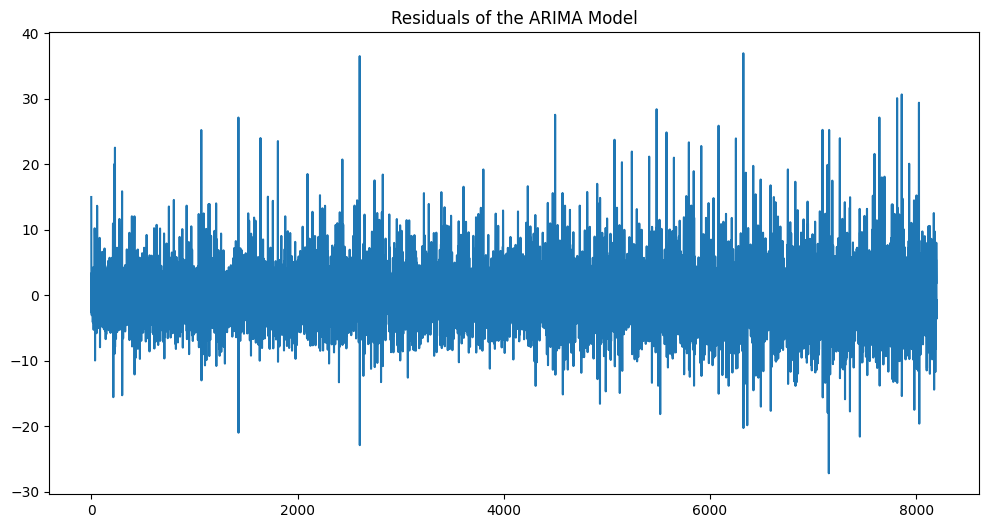

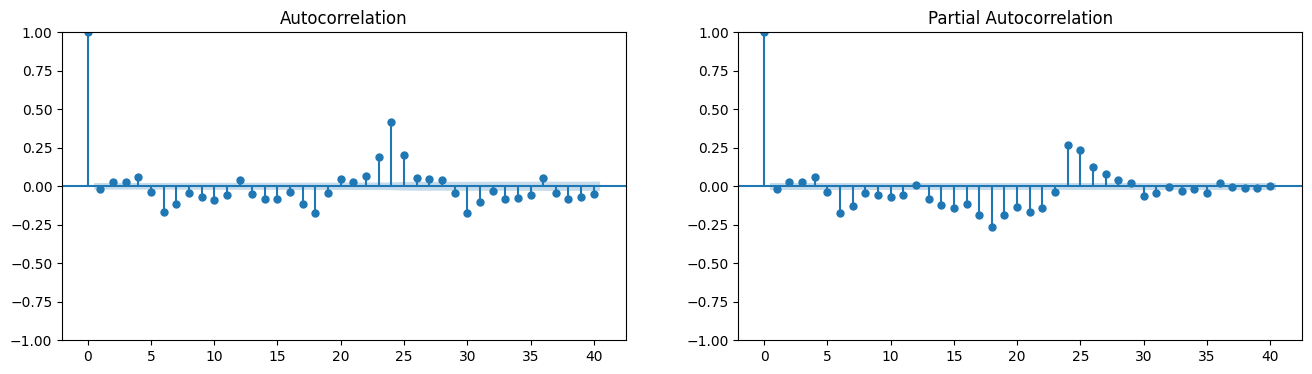

In [92]:

# For simplicity, let's assume p=1, d=1, q=1
p = 1
d = 1
q = 1

# Fit the ARIMA model
model = sm.tsa.ARIMA(train_df['EnergyConsumption(kWh)'], order=(p, d, q))
results = model.fit()

# Print the model summary
print(results.summary())

# Plot the residuals to check for any patterns
residuals = results.resid
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title('Residuals of the ARIMA Model')
plt.show()

# Plot the ACF and PACF of the residuals to check for any patterns
plot_acf_pacf(residuals)


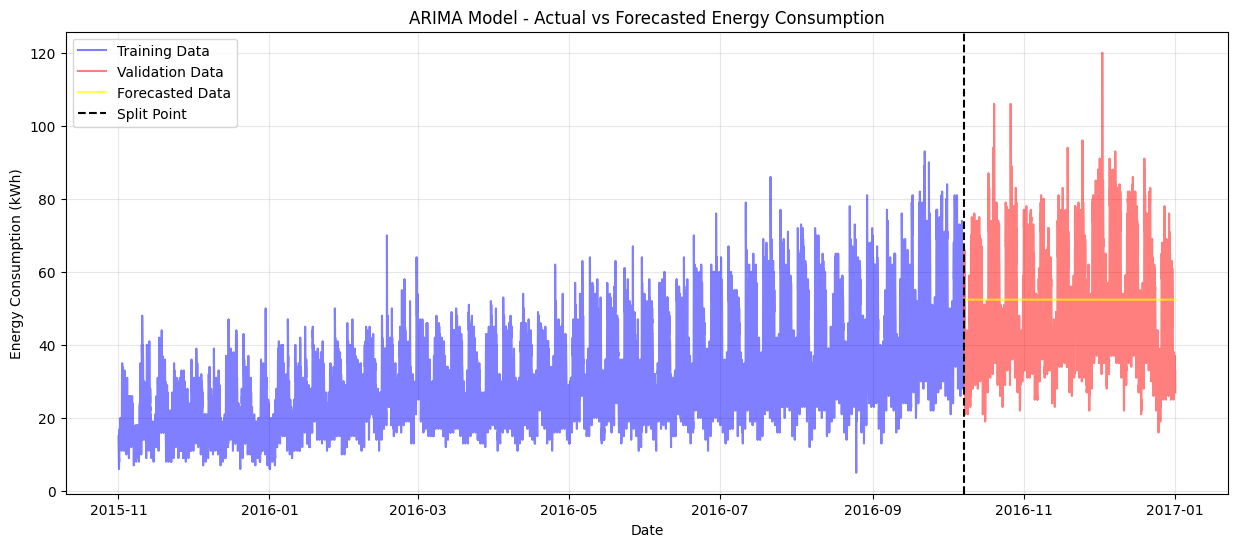

In [93]:
# Train and Validate Model

## Train the ARIMA model on the training data and validate its performance on the validation set

# Forecasting on the validation set
forecast_steps = len(val_df)
forecast = results.forecast(steps=forecast_steps)

# Create a DataFrame to store the forecasted values
forecast_df = val_df.copy()
forecast_df['Forecast'] = forecast

# Plot the actual vs forecasted values
plt.figure(figsize=(15, 6))
plt.plot(train_df['DateTime'], train_df['EnergyConsumption(kWh)'], label='Training Data', color='blue', alpha=0.5)
plt.plot(val_df['DateTime'], val_df['EnergyConsumption(kWh)'], label='Validation Data', color='red', alpha=0.5)
plt.plot(forecast_df['DateTime'], forecast_df['Forecast'], label='Forecasted Data', color='yellow', alpha=0.7)
plt.axvline(x=split_date, color='black', linestyle='--', label='Split Point')
plt.title('ARIMA Model - Actual vs Forecasted Energy Consumption')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (kWh)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


Mean Squared Error (MSE): 292.35
Mean Absolute Error (MAE): 14.82
Root Mean Squared Error (RMSE): 17.10


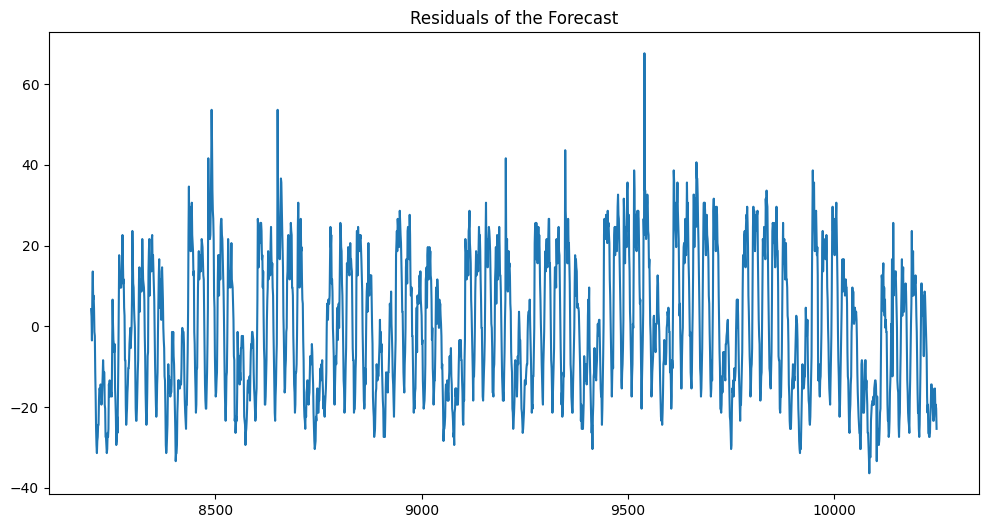

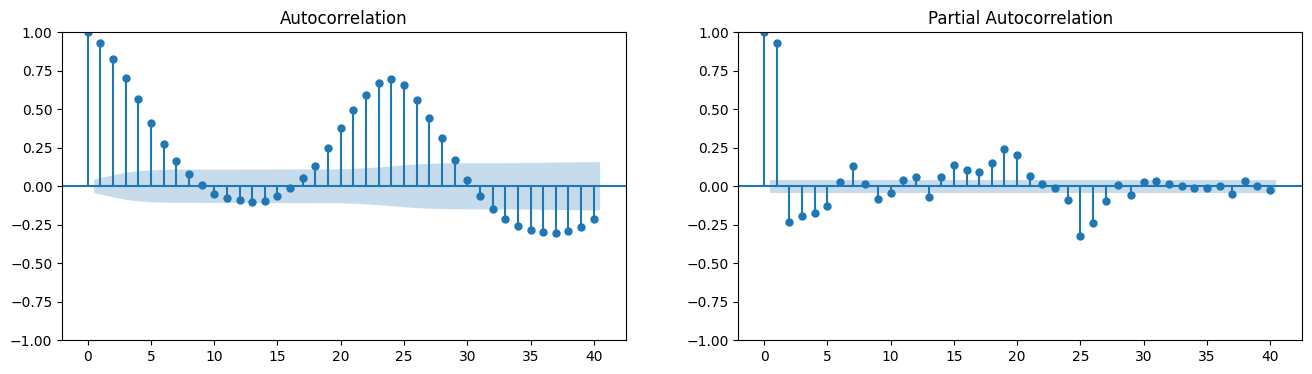

In [94]:

# Calculate performance metrics
mse = mean_squared_error(val_df['EnergyConsumption(kWh)'], forecast)
mae = mean_absolute_error(val_df['EnergyConsumption(kWh)'], forecast)
rmse = np.sqrt(mse)

print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

# Plot the residuals of the forecast
forecast_residuals = val_df['EnergyConsumption(kWh)'] - forecast
plt.figure(figsize=(12, 6))
plt.plot(forecast_residuals)
plt.title('Residuals of the Forecast')
plt.show()

# Plot the ACF and PACF of the forecast residuals to check for any patterns
plot_acf_pacf(forecast_residuals)

## Part 5 : Model Evaluation and Fine-Tuning

In [95]:
# Step 5: Model Evaluation and Fine-Tuning

### 5.1 Perform Grid Search for ARIMA Parameters
def grid_search_arima(train_data, p_range, d_range, q_range):
    """
    Perform grid search for ARIMA parameters
    """
    best_score = float("inf")
    best_params = None
    
    for p in p_range:
        for d in d_range:
            for q in q_range:
                try:
                    model = ARIMA(train_data, order=(p,d,q))
                    results = model.fit()
                    aic = results.aic
                    if aic < best_score:
                        best_score = aic
                        best_params = (p,d,q)
                    print(f'ARIMA({p},{d},{q}) - AIC: {aic}')
                except:
                    continue
    
    return best_params, best_score

# Define parameter ranges
p_range = range(0,3)
d_range = range(0,2) 
q_range = range(0,3)

# Perform grid search
best_params, best_aic = grid_search_arima(
    train_df['EnergyConsumption(kWh)'],
    p_range, d_range, q_range
)

print(f"Best ARIMA parameters: {best_params}")
print(f"Best AIC score: {best_aic}")


ARIMA(0,0,0) - AIC: 67413.94364455368


/home/adel_hb/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0,0,1) - AIC: 59418.5169685463


/home/adel_hb/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0,0,2) - AIC: 54970.67510398312
ARIMA(0,1,0) - AIC: 49806.49658339323
ARIMA(0,1,1) - AIC: 49610.921554885776
ARIMA(0,1,2) - AIC: 49526.38345569344
ARIMA(1,0,0) - AIC: 49576.22760964427
ARIMA(1,0,1) - AIC: 49311.467332011394
ARIMA(1,0,2) - AIC: 49170.72101274228
ARIMA(1,1,0) - AIC: 49569.263303634354
ARIMA(1,1,1) - AIC: 49491.85958169788
ARIMA(1,1,2) - AIC: 49474.89878312316
ARIMA(2,0,0) - AIC: 49226.8764454182
ARIMA(2,0,1) - AIC: 48971.85418467786
ARIMA(2,0,2) - AIC: 48939.06032831902
ARIMA(2,1,0) - AIC: 49489.42458001025
ARIMA(2,1,1) - AIC: 49479.01863008294


/home/adel_hb/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/adel_hb/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2,1,2) - AIC: 48181.48452513021
Best ARIMA parameters: (2, 1, 2)
Best AIC score: 48181.48452513021


In [96]:

### 5.2 Fit Model with Best Parameters
best_model = ARIMA(
    train_df['EnergyConsumption(kWh)'], 
    order=best_params
).fit()

# Make predictions
print(f"Forecasting {len(val_df)} steps ahead")
forecast = best_model.forecast(steps=len(val_df))


/home/adel_hb/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/adel_hb/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Forecasting 2050 steps ahead


In [97]:

### 5.3 Comprehensive Model Evaluation

# Calculate error metrics
def calculate_metrics(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    
    # Calculate percentage errors
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    
    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    }

metrics = calculate_metrics(
    val_df['EnergyConsumption(kWh)'],
    forecast
)

# Print metrics
print("\nModel Performance Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}")



Model Performance Metrics:
MSE: 319.51
RMSE: 17.87
MAE: 14.90
MAPE: 29.62


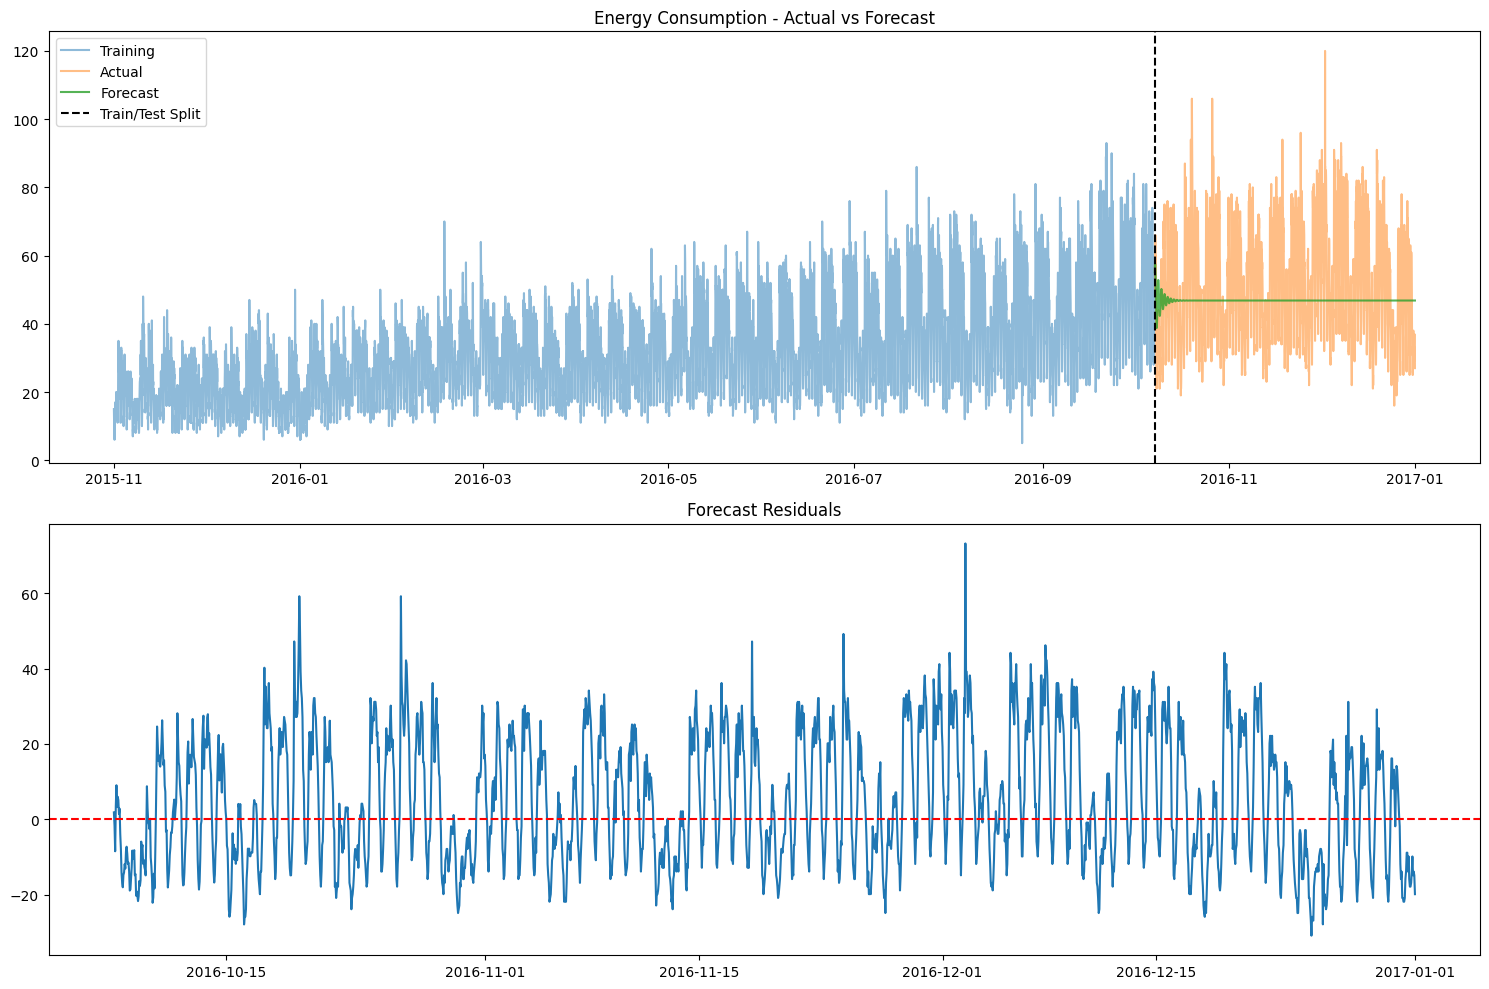

In [98]:

### 5.4 Visualization of Results

plt.figure(figsize=(15,10))

# Plot actual vs predicted values
plt.subplot(2,1,1)
plt.plot(train_df['DateTime'], train_df['EnergyConsumption(kWh)'], 
         label='Training', alpha=0.5)
plt.plot(val_df['DateTime'], val_df['EnergyConsumption(kWh)'], 
         label='Actual', alpha=0.5)
plt.plot(val_df['DateTime'], forecast, 
         label='Forecast', alpha=0.8)
plt.axvline(x=split_date, color='black', linestyle='--', label='Train/Test Split')
plt.title('Energy Consumption - Actual vs Forecast')
plt.legend()

# Plot residuals
plt.subplot(2,1,2)
residuals = val_df['EnergyConsumption(kWh)'] - forecast
plt.plot(val_df['DateTime'], residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Forecast Residuals')

plt.tight_layout()
plt.show()


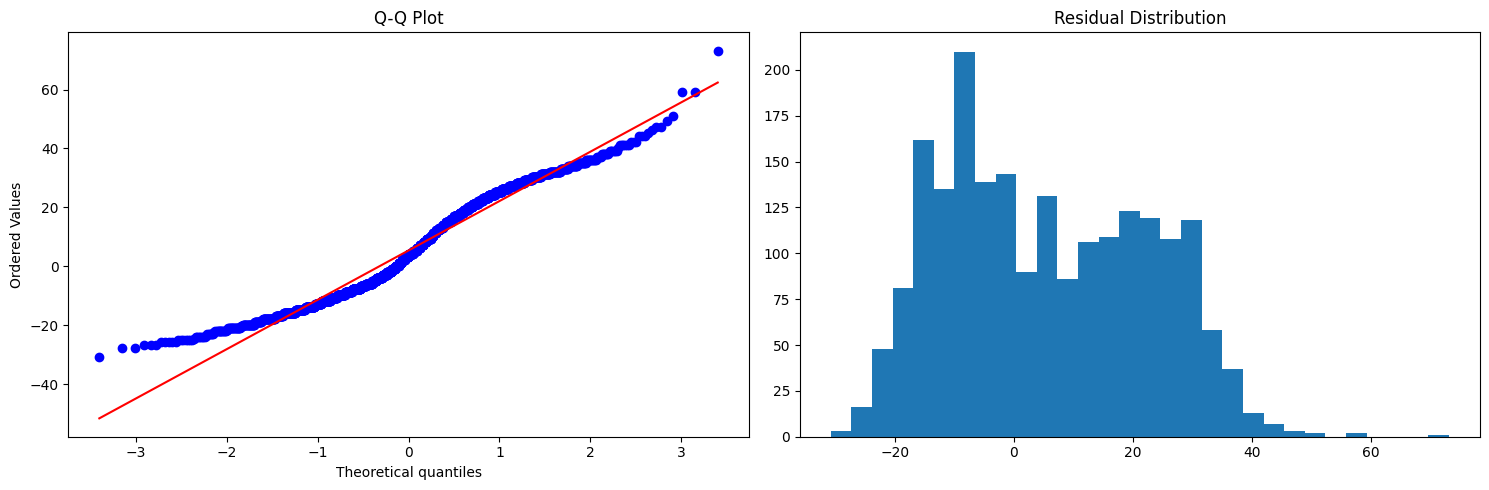


Residual Analysis:
Shapiro-Wilk Test (Normality):
ShapiroResult(statistic=np.float64(0.9644731482763136), pvalue=np.float64(4.774775909163194e-22))

Ljung-Box Test (Independence):
        lb_stat  lb_pvalue
10  5447.901778        0.0


In [99]:

### 5.5 Residual Analysis

plt.figure(figsize=(15,5))

# QQ Plot
from scipy import stats
plt.subplot(1,2,1)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot")

# Residual Histogram
plt.subplot(1,2,2)
plt.hist(residuals, bins=30)
plt.title("Residual Distribution")

plt.tight_layout()
plt.show()

# Statistical Tests
print("\nResidual Analysis:")
print("Shapiro-Wilk Test (Normality):")
print(stats.shapiro(residuals))

print("\nLjung-Box Test (Independence):")
from statsmodels.stats.diagnostic import acorr_ljungbox
print(acorr_ljungbox(residuals, lags=[10], return_df=True))


In [100]:

### 5.6 Time Series Cross Validation 

from sklearn.model_selection import TimeSeriesSplit

# Initialize Time Series Split
tscv = TimeSeriesSplit(n_splits=5)

# Store results
cv_scores = []

# Perform Cross Validation
for train_idx, val_idx in tscv.split(train_df):
    # Split data
    cv_train = train_df.iloc[train_idx]
    cv_val = train_df.iloc[val_idx]
    
    # Fit model
    model = ARIMA(cv_train['EnergyConsumption(kWh)'], order=best_params).fit()
    
    # Make predictions
    predictions = model.forecast(steps=len(cv_val))
    
    # Calculate error
    score = np.sqrt(mean_squared_error(cv_val['EnergyConsumption(kWh)'], predictions))
    cv_scores.append(score)

print("\nCross Validation Results:")
print(f"Average RMSE: {np.mean(cv_scores):.2f}")
print(f"Std RMSE: {np.std(cv_scores):.2f}")


/home/adel_hb/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Cross Validation Results:
Average RMSE: 15.83
Std RMSE: 4.18


In [101]:

### 5.7 Feature Importance Analysis

# For ARIMA, we can analyze coefficients
print("\nModel Coefficients:")
print(best_model.params)

### 5.8 Save Final Model

import joblib

# Save model
joblib.dump(best_model, 'final_arima_model.pkl')

print("\nModel saved successfully!")



Model Coefficients:
ar.L1      1.890241
ar.L2     -0.954144
ma.L1     -1.884228
ma.L2      0.912743
sigma2    20.860597
dtype: float64

Model saved successfully!


In [102]:
# 5.9 Generate Final Predictions using Test Data
# Load test data
test_df = pd.read_csv('data/test_energy.csv')
test_df['DateTime'] = pd.to_datetime(test_df['DateTime'])

# Generate predictions and handle NaN values
test_predictions = best_model.forecast(steps=len(test_df))
test_predictions = np.nan_to_num(test_predictions, nan=0)  # Replace NaN with 0

# Create DataFrame with exact matching format
submission_df = pd.DataFrame()
submission_df['DateTime'] = test_df['DateTime'].dt.strftime('%Y-%m-%d %H:%M:%S')
submission_df['EnergyConsumption(kWh)'] = np.round(test_predictions).astype(int)

# Ensure no NaN values in final DataFrame
submission_df = submission_df.fillna(0)

# Save with exact format matching
submission_df.to_csv('arima_predictions.csv', 
                    index=False, 
                    float_format='%d',  # Force integer format
                    lineterminator='\n')  # Ensure Unix line endings

# Verify format and check for NaN values
print("Sample of generated file:")
print(pd.read_csv('arima_predictions.csv').head().to_string())
print("\nChecking for NaN values:")
print(submission_df.isna().sum())

Sample of generated file:
              DateTime  EnergyConsumption(kWh)
0  2017-01-01 01:00:00                      55
1  2017-01-01 02:00:00                      57
2  2017-01-01 03:00:00                      57
3  2017-01-01 04:00:00                      58
4  2017-01-01 05:00:00                      57

Checking for NaN values:
DateTime                  0
EnergyConsumption(kWh)    0
dtype: int64
